# Generative adversarial networks

Цель: научиться работать с GAN-ами

Задачи:
- вручную реализовать вариацию DCGAN
- обучить предсказывать лица людей
- измерить метрики качества генерируемых изображений

In [1]:
import os
import gc
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
from torch import Tensor
from torch.nn import Parameter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchsummary import summary
import timm
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import model_selection, neighbors, metrics, manifold
from scipy.linalg import sqrtm
from IPython.display import clear_output
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

Попробуем сделать работу программы повторяемой...

In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

random_seed = 2077
seed_everything(random_seed)

В windows не работает параметр num_workers, поэтому сразу пропишем его.

In [3]:
if 'nt' in os.name:
    num_workers = 0
    path = 'D:/DATASETS_ML/faces_dataset/'
else:
    num_workers = 8
    path = '/home/sergey/DATASETS_ML/faces_dataset/'
print('num_workers =', num_workers)

num_workers = 8


In [4]:
def clear_GPU():
    gc.collect()
    torch.cuda.empty_cache()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Введем некоторые гиперпараметры.

Отметим, что:
- в дискриминаторе есть много послойного шума
- в генераторе есть дропаут и очень слабый послойный шум

WGAN реализован в коде, но почему-то классический DCGAN с использованными лайфхаками учится лучше.

In [6]:
num_colors = 3
image_size = 128
latent_size = 128

small_dataset_k = 1

# discriminator parameters
d_drop = 0.0 # dropout rate
d_leak = 0.2 # leaky relu rate
d_noise = dict(
    gauss_std = 0.1, # add noise before every convolution
    std_decay_rate = 0.#15 / 200 # linear noise decay over 1 epoch
)

# generator parameters
g_drop = 0.3
g_leak = 0.0
g_noise = dict(
    gauss_std = 0.01,
    std_decay_rate = 0.0#2 / 200
)

c_lambda = 10
wgan_clip_weight = 0.01

min_feature_size = 64
stats = np.array([0.5] * num_colors), np.array([0.5] * num_colors)

## Часть 1. Подготовка данных

В качестве обучающей выборки возьмем датасет [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024).

In [7]:
class FaceDataset(Dataset):
    def __init__(self, path, image_size=128, transform=None, dataset_divide=1, noise_k = 0.):
        self.path = path
        self.transform = transform
        self.noise_k = noise_k
        
        if dataset_divide == None:
            dataset_divide = 1
        self.dataset_divide = dataset_divide
        
        self.basic_transform = A.Compose(
            [
                A.Resize(image_size, image_size, interpolation=cv2.INTER_LINEAR),
                A.HorizontalFlip(),
                A.Normalize(*stats),
                ToTensorV2(),
            ]
        )
        
        self.files = []
        for dirpath, dirnames, filenames in os.walk(path):
            self.files.extend([os.path.join(dirpath, file) for file in filenames if '.png' in file])
        
        if small_dataset_k < 1:
            self.files = self.files[:int(len(self.files) * small_dataset_k)]
        
        print(f'loaded {len(self.files)} files')

    def __len__(self):
        if self.dataset_divide > 1:
            return len(self.files) // self.dataset_divide
        else:
            return len(self.files)

    def __getitem__(self, idx):
        image_filepath = self.files[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
            
        image = self.basic_transform(image=image)['image']
        if self.noise_k > 0:
            image += torch.randn_like(image) * self.noise_k
        
        return image.float()

Будем создавать даталоадер функцией.

In [8]:
batch_size = 25
dataset_divide = 1
fixed_latent = torch.randn(25, latent_size, device=device)

In [9]:
def get_dataloader(path, image_size=128, transform=None, 
                   batch_size=16, dataset_divide=dataset_divide):
    ds = FaceDataset(path, image_size, transform, dataset_divide)
    dl = DataLoader(ds, 
                    batch_size=batch_size, 
                    shuffle=True, 
                    num_workers=num_workers)
    return dl

dl = get_dataloader(path=path, image_size=image_size, 
                                transform=None, batch_size=batch_size, 
                                dataset_divide=dataset_divide)

loaded 70000 files


Мы часто будем визуализировать картинки, так что вот некоторые функции для этого.

In [10]:
def denorm(img_tensors):
    img_tensors = img_tensors * stats[1][0] + stats[0][0]
    return img_tensors

def show_images(images, nmax=16, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(
        make_grid(
            denorm(images.detach()[:nmax]), 
            nrow=int(nmax ** 0.5)
        ).permute(1, 2, 0)
    )

def show_batch(dl, nmax=25):
    for images in dl:
        show_images(images, nmax)
        break

Посмотрим на то, как выглядит наш батч.

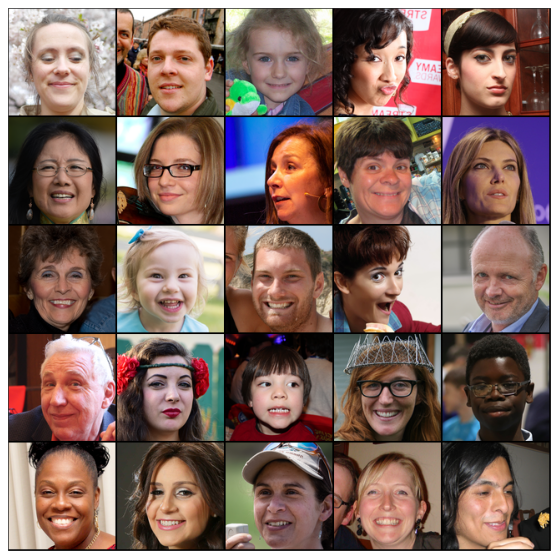

In [11]:
show_batch(dl)

## Часть 2. Построение и обучение модели

В статье по DCGAN предлагается инициализировать веса с вполне конкретными распределениями.

In [12]:
def weights_init(m):
    default_std = 0.02
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, default_std)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, default_std)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, default_std)
        try:
            nn.init.constant_(m.bias.data, 0)
        except Exception:
            pass

## Новые модули нейросети

Для реализации всяких интересных идей нам понадобятся собственные блоки.

Пиксельная нормализация (может быть использована в генераторе вместо батч-норм)

In [13]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

Слой, добавляющий гауссовский шум каждому пикселю с возможностью его ослабления по эпохам.

In [14]:
class GaussianNoise(nn.Module):
    def __init__(self, gauss_std=0.1, std_decay_rate=0):
        super().__init__()
        self.std = gauss_std
        self.decay_rate = std_decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

Функция, вызываемая в конце эпохи для линейного ослабления шума (чтобы модель "доучивалась" с ослабленным шумом).

In [15]:
def decay_gauss_std(net):
    for m in net.modules():
        if isinstance(m, GaussianNoise):
            m.decay_step()

### Дискриминатор

Будем собирать его из "блоков".

In [16]:
def discriminator_block(out_channels, 
                        kernel_size=4, stride=2, padding=1,
                        normalization=True):
    
    block = []
    
    if d_noise['gauss_std'] > 0:
        block.append(GaussianNoise(**d_noise))
        
    block.append(nn.LazyConv2d(
        int(out_channels), kernel_size, stride, padding, 
        bias=not normalization)
    )

    if normalization:
        block.append(nn.LazyBatchNorm2d())

    block.append(nn.LeakyReLU(d_leak, inplace=True))

    if d_drop > 0: block.append(nn.Dropout2d(d_drop))

    return nn.Sequential(*block)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, feature_size=64):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            discriminator_block(feature_size * 1),
            discriminator_block(feature_size * 2),
            discriminator_block(feature_size * 4),
            discriminator_block(feature_size * 8),
            discriminator_block(feature_size * 16),
            nn.Flatten(1,3),
        )
        
        self.head = nn.Sequential(
            GaussianNoise(**d_noise),
            nn.LazyLinear(1, bias=False),
        )
            
    def forward(self, input):
        input = self.conv(input)
        input = self.head(input)
        return input

Проверим, как он работает.

In [18]:
discriminator = Discriminator()
test_sample = torch.randn(batch_size, num_colors, image_size, image_size)
print(test_sample.shape)
with torch.no_grad():
    r = discriminator(test_sample)
print(r.shape)
discriminator.apply(weights_init);

torch.Size([25, 3, 128, 128])
torch.Size([25, 1])


/home/sergey/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
discriminator

Discriminator(
  (conv): Sequential(
    (0): Sequential(
      (0): GaussianNoise()
      (1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): GaussianNoise()
      (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): GaussianNoise()
      (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): GaussianNoise()
      (1): Conv2d(256, 512, kernel_size=(4, 

In [20]:
summary(discriminator.to(device), input_size=(num_colors, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     GaussianNoise-1          [-1, 3, 128, 128]               0
            Conv2d-2           [-1, 64, 64, 64]           3,072
       BatchNorm2d-3           [-1, 64, 64, 64]             128
         LeakyReLU-4           [-1, 64, 64, 64]               0
     GaussianNoise-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 32, 32]         131,072
       BatchNorm2d-7          [-1, 128, 32, 32]             256
         LeakyReLU-8          [-1, 128, 32, 32]               0
     GaussianNoise-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 16, 16]         524,288
      BatchNorm2d-11          [-1, 256, 16, 16]             512
        LeakyReLU-12          [-1, 256, 16, 16]               0
    GaussianNoise-13          [-1, 256, 16, 16]               0
           Conv2d-14            [-1, 51

### Генератор

Тоже из блоков.

In [21]:
def generator_block(out_channels, 
                    kernel_size=4, stride=2, padding=1, output_padding=0,
                    normalization='batch'
                   ):
    
    bias = True if normalization == None else False
    
    block = []
    
    if g_noise['gauss_std'] > 0:
        block.append(GaussianNoise(**g_noise))
        
    block.append(nn.LazyConvTranspose2d(
        int(out_channels), kernel_size, stride, padding, bias=bias)
    )

    if normalization == 'batch':
        block.append(nn.LazyBatchNorm2d())

    if g_leak > 0:
        block.append(nn.LeakyReLU(g_leak, inplace=True))
    else:
        block.append(nn.ReLU(inplace=True))

    if normalization == 'pixel':
        block.append(PixelNorm())
        
    if g_drop > 0: block.append(nn.Dropout2d(g_drop))

    return nn.Sequential(*block)

In [22]:
class Generator(nn.Module):
    def __init__(self, num_colors=3, min_feature_size=64):
        super(Generator, self).__init__()
        
        bias = False
        kernel_size = 4
        stride = 2
        padding = 1
        output_padding = 0
        
        self.grid_from_vector = nn.Sequential(
            nn.Unflatten(1, (-1, 1, 1)),
            generator_block(min_feature_size * 16, stride=1, padding=0)
        )
        
        self.upsample = nn.Sequential(
            generator_block(min_feature_size * 8),
            generator_block(min_feature_size * 4),
            generator_block(min_feature_size * 2),
            generator_block(min_feature_size * 1),
        )
        
        self.to_color = nn.Sequential(
            nn.LazyConvTranspose2d(3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, input):
        output = self.grid_from_vector(input)
        output = self.upsample(output)
        output = self.to_color(output)
        return output

Проверка.

In [23]:
generator = Generator(num_colors, min_feature_size)

torch.Size([25, 3, 128, 128])


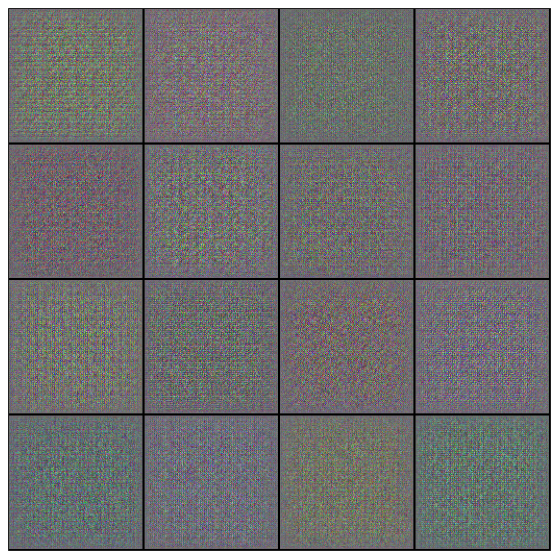

In [24]:
test_sample = torch.randn(batch_size, latent_size)
with torch.no_grad():
    fake_images = generator(test_sample)
generator.apply(weights_init)
test_sample = torch.randn(batch_size, latent_size)
with torch.no_grad():
    fake_images = generator(test_sample)
print(fake_images.shape)
show_images(fake_images)

In [25]:
summary(generator.to(device), input_size=tuple([latent_size]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Unflatten-1            [-1, 128, 1, 1]               0
     GaussianNoise-2            [-1, 128, 1, 1]               0
   ConvTranspose2d-3           [-1, 1024, 4, 4]       2,097,152
       BatchNorm2d-4           [-1, 1024, 4, 4]           2,048
              ReLU-5           [-1, 1024, 4, 4]               0
         Dropout2d-6           [-1, 1024, 4, 4]               0
     GaussianNoise-7           [-1, 1024, 4, 4]               0
   ConvTranspose2d-8            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
             ReLU-10            [-1, 512, 8, 8]               0
        Dropout2d-11            [-1, 512, 8, 8]               0
    GaussianNoise-12            [-1, 512, 8, 8]               0
  ConvTranspose2d-13          [-1, 256, 16, 16]       2,097,152
      BatchNorm2d-14          [-1, 256,

In [26]:
generator

Generator(
  (grid_from_vector): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(-1, 1, 1))
    (1): Sequential(
      (0): GaussianNoise()
      (1): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Dropout2d(p=0.3, inplace=False)
    )
  )
  (upsample): Sequential(
    (0): Sequential(
      (0): GaussianNoise()
      (1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): GaussianNoise()
      (1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Функция, чтобы быстренько выводить количество обучаемых параметров.

In [27]:
def get_param_num(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

Для удобства сделаем одну функцию для инициализации обеих нейросетей.

In [28]:
def reset_networks(min_feature_size = 64, weak_discriminator_k = 1):
    clear_GPU()
    clear_GPU()
    
    generator = Generator(num_colors, int(min_feature_size))
    discriminator = Discriminator(int(min_feature_size // weak_discriminator_k))
    
    with torch.no_grad():
        test_sample = torch.randn(batch_size, latent_size)
        generator(test_sample)
        
    with torch.no_grad():
        test_sample = torch.randn(batch_size, num_colors, image_size, image_size)
        discriminator(test_sample)
    
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    print('discriminator param number', get_param_num(discriminator))
    print('generator param number', get_param_num(generator))
    
    return generator, discriminator

### Классификатор для метрики качества

В качестве классификатора нам нужен предобученный на imagenet надежный классификатор. Возьмем его из [библиотеки TIMM](https://rwightman.github.io/pytorch-image-models/feature_extraction/).

Например, мне нравится resnet. Посмотрим, какие резнеты там есть.

In [29]:
timm.list_models('inc*', pretrained=True)

['inception_resnet_v2', 'inception_v3', 'inception_v4']

Возьмем, например, inception_v3.

In [30]:
classifier = timm.create_model('inception_v3', pretrained=True, num_classes=0)
classifier.eval();

Удостоверимся, что он сработает с нашей картинкой (ее размер вообще-то не соответствует размеру для резнета)

In [31]:
test_sample = torch.randn(batch_size, 3, image_size, image_size)
classifier(test_sample).shape

torch.Size([25, 2048])

Предобученные классификаторы хотят получать на вход нормированные данные. Посмотрим, какие нормировки нужны нашей модели.

In [32]:
cfg = classifier.default_cfg
stats_class = cfg['mean'], cfg['std']
input_size_class = cfg['input_size'][1]
stats_class, input_size_class

(((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 299)

А теперь напишем функцию, принимающую на вход батч картинок, нормированных для дискриминатора (0.5), снимающую эту нормировку и делающую новую нормировку для резнета.

В конце функция возвращает таблицу эмбеддингов.

In [33]:
def classify_batch(images_batch):
    # все картинки хранятся нормализованными со stats
    # денормализуем
    de_norm = tt.Normalize(-stats[0], 1 / stats[1])
    images_batch = de_norm(images_batch)
    
    # нормализуем под наш классификатор
    class_norm = tt.Normalize(stats_class[0], stats_class[1])
    images_batch = class_norm(images_batch)
    
    
    with torch.no_grad():
        # images_batch = F.interpolate(images_batch, size=input_size_class)
        images_batch = classifier(images_batch).cpu().detach().numpy()
    return images_batch

Проверка.

In [34]:
classify_batch(test_sample).shape

(25, 2048)

# Вспомогательные функции для обучения

Мы хотим сразу делать много-много вещей, в частности, строить графики и сохранять результаты в файлы.

Поэтому потребуется множество функций.

Освобождение папки для генерируемых картинок:

In [35]:
sample_dir = './outputs/'

def empty_output_dir(mydir='./outputs'):
    list(
        map(
            os.unlink, 
            (os.path.join(mydir,f) for f in os.listdir(mydir))
        ) 
    )

Сшивание картинок в анимацию:

In [36]:
def create_gif(sample_dir):
    gif_file = sample_dir + '_animated_.gif'
    png_s_mask = sample_dir + '*.png'

    imgs = (Image.open(f) for f in sorted(glob.glob(png_s_mask)))
    img = next(imgs)  # extract first image from iterator
    img.save(fp=gif_file, format='GIF', append_images=imgs,
             save_all=True, duration=1000*4//24, loop=0)

Вывод на экран и в файл набора картинок. Важно: картинки всегда генерируются из одного и того же латентного вектора.

In [37]:
def save_samples(generator, epoch, latent_tensors, show=True, save=True):
    
    generator.eval()
    latent_tensors = latent_tensors.clone()
    with torch.no_grad():
        fake_images = generator(latent_tensors)
        
    if save:
        fake_fname = f'generated-images-{epoch:05d}.png'
        save_image(
            denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=5
        )
        print('Saving', fake_fname)
        
    if show:
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(
            make_grid(denorm(fake_images.cpu().detach()), nrow=5).permute(1, 2, 0)
        )
        plt.show()

Самое интересное - буфер для сгенерированных картинок. Мы заполняем его на первой итерации, а затем на каждой итерации удаляем самые старые картинки и добавляем новые. При обучении выбираем из буфера случайный набор картинок на половину батча.

In [38]:
class image_buffer():
    def __init__(self, num_batches=3, batch_size=None):
        self.num_batches = num_batches
        self.images = None
        self.batch_size = batch_size
    
    def get_part_batch(self, part=0.5):
        num_to_return = round(self.batch_size * part)
        full_index_list = [i for i in range(self.images.shape[0])]
        idx = np.random.choice(full_index_list, num_to_return, replace=False)
        
        if len(idx) < num_to_return:
            print('not enough images in buffer!!!')
            return None
        
        output = self.images[idx]
        keep_index_list = [i for i in full_index_list if i not in idx]
        self.images = self.images[keep_index_list]
        return output
    
    def add_images(self, batch_image_tensor):
        batch_image_tensor.cpu().detach()
        if self.images == None:
            self.images = batch_image_tensor
            if self.batch_size == None:
                self.batch_size = batch_image_tensor.shape[0]
            self.max_num_images = self.batch_size * self.num_batches
        else:
            self.images = torch.concat([batch_image_tensor, self.images], 0)
        
        if self.images.shape[0] > self.max_num_images:
            self.images = self.images[:self.max_num_images]
        
    def get_num_req_batches(self):
        return int(np.ceil((self.max_num_images - len(self.images)) / self.batch_size))

Одна из важнейших функций - кривые лосса и точности дискриминатора.

In [39]:
def plot_train_curves(history, name=None):
    losses_g, losses_d = history['losses_g'], history['losses_d']
    real_scores, fake_scores = history['real_scores'], history['fake_scores']
    losses_d_real, losses_d_fake = history['losses_d_real'], history['losses_d_fake']
    if len(losses_g) < 2: return None
    
    if 'fids' in history.keys():
        fids = history['fids']
    else:
        fids = []
        
    if 'loos' in history.keys():
        loos = history['loos']
    else:
        loos = []
        
    x = np.arange(len(losses_d)) + 1
    
    fig = plt.figure(figsize=(9,9))
    fig.patch.set_facecolor('xkcd:white')
    
    plt.subplot(4,1,1)
    # plt.plot(x, losses_g, label="generator loss")
    plt.plot(x, losses_d_real, label="discriminator loss (real)")
    plt.plot(x, losses_d_fake, label="discriminator loss (fake)")
    plt.plot(x, losses_g, label="generator loss")
    plt.legend()
    # plt.xlabel("epochs")
    plt.ylabel("loss")
    
    plt.subplot(4,1,2)
    plt.plot(x, real_scores, label="real ACC")
    plt.plot(x, fake_scores, label="fake ACC")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("discriminator scores")
    
    if len(loos) >= 2:
        plt.subplot(4,1,3)
        plt.plot(loos[:,0], loos[:,1], label="Leave-One-Out accuracy")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("LOO accuracy")
    
    if len(fids) >= 2:
        plt.subplot(4,1,4)
        plt.plot(fids[:,0], fids[:,1], label="FID")
        plt.legend()
        # plt.xlabel("epochs")
        plt.ylabel("Frechet Inc Dist")    
    
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.show()

## Метрики качества

Реализуем сразу все метрики.

### Leave-one-out-1-NN classifier

Берем на вход два массива эмбеддингов, делаем многократную разбивку Leave-one-out, считаем точность разделения настоящих и сгенерированных картинок. Чем ниже, тем лучше.

In [40]:
%%time
array_real = np.random.randn(300, 512)
array_fake = np.random.randn(10000, 512) + 0.2

def loo_class_acc(array_real, array_fake, num_from_array = None):

    if num_from_array == None:
        num_from_array = np.min((array_real.shape[0], array_fake.shape[0]))
        
    if array_real.shape[0] < num_from_array or array_fake.shape[0] < num_from_array:
        num_from_array = np.min((array_real.shape[0], array_fake.shape[0]))
    
    idx = np.random.choice(np.arange(array_real.shape[0]), num_from_array, replace=False)
    array_real = array_real[idx]
    
    idx = np.random.choice(np.arange(array_fake.shape[0]), num_from_array, replace=False)
    array_fake = array_fake[idx]
    
    targets_real = np.ones((array_real.shape[0]))
    targets_fake = np.zeros((array_fake.shape[0]))
    full_array = np.vstack((array_real, array_fake))
    full_targets = np.concatenate((targets_real, targets_fake))

    loo = model_selection.LeaveOneOut()
    kn_classifier = neighbors.KNeighborsClassifier(n_neighbors=1, n_jobs=1)
    
    res = []
    gt = []
    
    for train_index, test_index in loo.split(full_array):
        kn_classifier.fit(full_array[train_index], full_targets[train_index])
        res.append(kn_classifier.predict(full_array[test_index]).item())
        gt.append(full_targets[test_index].item())

        pass
    
    acc = metrics.accuracy_score(res, gt)
    return acc

loo_class_acc(array_real, array_fake, 100000)

CPU times: user 5.05 s, sys: 1.67 ms, total: 5.06 s
Wall time: 477 ms


0.795

Будем еще визуализировать TSNE картинку на плоскости для этих эмбеддингов.

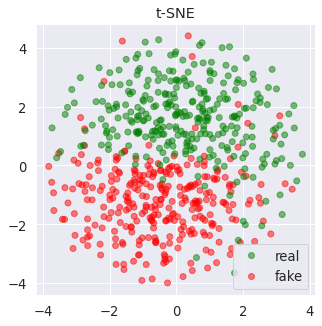

CPU times: user 7.84 s, sys: 8.46 ms, total: 7.85 s
Wall time: 726 ms


In [41]:
%%time

def tsne_2d(array_real, array_fake, num_from_array = None, **kwargs):

    if num_from_array == None:
        num_from_array = np.min((array_real.shape[0], array_fake.shape[0]))
        
    if array_real.shape[0] < num_from_array or array_fake.shape[0] < num_from_array:
        num_from_array = np.min((array_real.shape[0], array_fake.shape[0]))
    
    idx = np.random.choice(np.arange(array_real.shape[0]), num_from_array, replace=False)
    array_real = array_real[idx]
    
    idx = np.random.choice(np.arange(array_fake.shape[0]), num_from_array, replace=False)
    array_fake = array_fake[idx]
    
    targets_real = np.ones((array_real.shape[0]))
    targets_fake = np.zeros((array_fake.shape[0]))
    full_array = np.vstack((array_real, array_fake))
    full_targets = np.concatenate((targets_real, targets_fake))

    t_sne = manifold.TSNE(
        n_components=2,
        # learning_rate="auto",
        perplexity=50,
        early_exaggeration=14,
        # n_iter=500,
        init="random",
        **kwargs
    )
    
    array_2d = t_sne.fit_transform(full_array)

    plt.figure(figsize=(5,5))
    scatter = plt.scatter(x=array_2d[:,0], 
                y=array_2d[:,1], 
                c=full_targets,
                alpha=0.5,
                cmap=matplotlib.colors.ListedColormap(['green', 'red'])
               )
    plt.legend(handles=scatter.legend_elements()[0],
               labels=['real', 'fake'])
    plt.title('t-SNE')
    plt.show()
    
tsne_2d(array_real, array_fake, 750)

### Fréchet inception distance

Некая "мера похожести" двух многомерных множеств.

In [42]:
# calculate frechet inception distance
def calculate_fid(images1, images2):
    # calculate mean and covariance statistics
    mu1, sigma1 = images1.mean(axis=0), np.cov(images1, rowvar=False)
    mu2, sigma2 = images2.mean(axis=0), np.cov(images2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Функции обучения

Введем лосс, пытающийся приравнять L2-норму всех градиентов дискриминатора к единице. Называется Gradient Penalty, списано с гитхаба.

In [43]:
def gradient_of_critic_score(critic, real, fake, flip=False):
    
    epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)

    interpolated_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = critic(interpolated_images)

    if flip:
        gradient = torch.autograd.grad(
            inputs=interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.zeros_like(mixed_scores),
            create_graph=True,
            retain_graph=True,
        )[0]
    else:
        gradient = torch.autograd.grad(
            inputs=interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.ones_like(mixed_scores),
            create_graph=True,
            retain_graph=True,
        )[0]
    return gradient

def gradient_penalty_l2_norm(gradient):

    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)

    penalty = torch.mean((gradient_norm - 1) ** 2)

    return penalty

Самая важная функция: обучение дискриминатора и генератора.

In [44]:
def fit(model, criterion, optimizer, dl, 
        scheduler=None, epochs=1, 
        noised_real_labels=0.0,
        noised_fake_labels=0.0, 
        soft_real_labels=0.0,
        soft_fake_labels=0.0, 
        buffer_batches=4, 
        extract_features_epoch=-1, 
        fixed_latent=None, 
        flip_target=False, 
        flip_positive_part=0.,
        flip_fake_part=0.,
        noise_real_images=0.0, 
        noise_fake_images=0.0, 
        wgan=False, 
        n_critic_per_gen=1,
        sigmoid_in_model=True,
        train_phases=True,
        loss_lim_dis=0.5,
        loss_lim_gen=0.5,
        grad_penalty_k=0.,
        samples_for_loo=300
       ):
    
    if wgan:
        noise_real_images=0.0
        noise_fake_images=0.0
        flip_target=False
        
    if n_critic_per_gen < 1:
        n_critic_per_gen = 1
        
    max_real_accuracy = (1 - soft_real_labels - 0.5 * noised_real_labels)*(1-flip_positive_part)
    max_fake_accuracy = (1 - soft_fake_labels - 0.5 * noised_fake_labels)*(1-flip_fake_part)
    
    empty_output_dir(sample_dir)
    
    model["discriminator"].train()
    model["generator"].train()
    model["discriminator"].to(device)
    model["generator"].to(device)
    classifier.to(device)
    
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    losses_d_real = []
    losses_d_fake = []
    real_scores = []
    fake_scores = []
    fids = np.array([0,0])
    loos = np.array([0,0])
    
    real_feature_matrix = None
    extract_features = False
    
    
    
    phase = 'discriminator'
    
    batch_size = None
    
    for epoch in range(epochs):
        
        model["discriminator"].train()
        model["generator"].train()
        
        iterations = dict(total=0, dis=0, gen=0)
        
        if extract_features_epoch > 0:
            if epoch % extract_features_epoch == 0:
                extract_features = True
                fake_feature_matrix = None
            else:
                extract_features = False
        
        loss_d_per_epoch = []
        loss_d_real_per_epoch = []
        loss_d_fake_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        
        for i, real_images in enumerate(tqdm(dl)):
            
            if batch_size == None:
                batch_size = real_images.shape[0]
                buff = image_buffer(num_batches=buffer_batches, batch_size=batch_size)
            if real_images.shape[0] != batch_size:
                continue
            
            iterations['total'] += 1
            
            # ----------------------------------
            # train discriminator
            # ----------------------------------
            
            if (not train_phases) or (phase == 'discriminator') or (i == 0):

                model["discriminator"].requires_grad_ = True
                model["generator"].requires_grad_ = False

                if noise_real_images > 0:
                    n = noise_real_images * (epochs - epoch - 1) / epochs
                    real_images += torch.randn_like(real_images) * n

                real_images = real_images.to(device)

                if epoch == 0 and extract_features:
                    batch_features = classify_batch(real_images)
                    if type(real_feature_matrix) == type(None):
                        real_feature_matrix = batch_features
                    elif len(real_feature_matrix) < samples_for_loo:
                        real_feature_matrix = np.concatenate([real_feature_matrix, batch_features], 0)

                # Pass real images through discriminator
                real_preds = model["discriminator"](real_images)
                
                if sigmoid_in_model:
                    tmp = real_preds
                else:
                    tmp = torch.sigmoid(real_preds)
                cur_real_score = torch.mean(tmp).item()
                
                real_targets = torch.ones_like(real_preds, device=device)
                
                if noised_real_labels > 0:
                    real_targets -= torch.rand_like(real_targets, device=device) * noised_real_labels
                if soft_real_labels > 0:
                    real_targets -= soft_real_labels
                if flip_positive_part > 0:
                    noise = torch.rand_like(real_targets, device=device)
                    mask = noise > flip_positive_part
                    real_targets = real_targets * mask
                if flip_target:
                    real_targets = 1 - real_targets
                    cur_real_score = 1 - cur_real_score

                if wgan:
                    real_loss = -torch.mean(real_preds)
                else:
                    real_loss = criterion["discriminator"](real_preds, real_targets)
                # print('real labels \n', torch.hstack([torch.sigmoid(real_preds),real_targets])[:8])

                # Generate fake images
                latent = torch.randn(real_images.shape[0], latent_size, device=device)
                with torch.no_grad():
                    fake_images = model["generator"](latent)

                if extract_features:
                    batch_features = classify_batch(fake_images)
                    if type(fake_feature_matrix) == type(None):
                        fake_feature_matrix = batch_features
                    elif len(fake_feature_matrix) < samples_for_loo:
                        fake_feature_matrix = np.concatenate([fake_feature_matrix, batch_features], 0)

                # Fill buffer
                fake_images_to_buffer = fake_images[batch_size//2:]
                fake_images_to_buffer = fake_images_to_buffer.cpu().detach()
                fake_images = fake_images[:batch_size//2] # leave half of current batch

                buff.add_images(fake_images_to_buffer)
                if buff.get_num_req_batches() > 0:
                    for _ in range(buff.get_num_req_batches()):
                        latent = torch.randn(batch_size, latent_size, device=device)
                        fake_images_to_buffer = model["generator"](latent)
                        fake_images_to_buffer = fake_images_to_buffer.cpu().detach()
                        buff.add_images(fake_images_to_buffer)

                fake_images_from_buffer = buff.get_part_batch()
                fake_images_from_buffer = fake_images_from_buffer.to(device)
                fake_images = torch.concat([fake_images, fake_images_from_buffer], 0)
                
                if noise_fake_images > 0:
                    fake_images += torch.randn_like(fake_images) * noise_fake_images

                # Pass fake images through discriminator

                fake_preds = model["discriminator"](fake_images)
                
                if sigmoid_in_model:
                    tmp = fake_preds
                else:
                    tmp = torch.sigmoid(fake_preds)
                cur_fake_score = 1 - torch.mean(tmp).item()
                    
                fake_targets = torch.zeros_like(fake_preds, device=device)
                
                if noised_fake_labels > 0:
                    fake_targets += torch.rand_like(fake_targets, device=device) * noised_fake_labels
                if soft_fake_labels > 0:
                    fake_targets += soft_fake_labels
                if flip_fake_part > 0:
                    noise = torch.rand_like(fake_targets, device=device)
                    mask = noise > flip_fake_part
                    fake_targets = fake_targets * mask + (1 - 1 * mask)
                if flip_target:
                    fake_targets = 1 - fake_targets
                    cur_fake_score = 1 - cur_fake_score
                
                if wgan:
                    fake_loss = torch.mean(fake_preds)
                else:
                    fake_loss = criterion["discriminator"](fake_preds, fake_targets)
                # print('fake labels \n', torch.hstack([torch.sigmoid(fake_preds), fake_targets])[:8])

                real_score_per_epoch.append(cur_real_score)
                fake_score_per_epoch.append(cur_fake_score)

                # Update discriminator weights
                model["discriminator"].zero_grad()
                loss_d = real_loss + fake_loss
                loss_d_per_epoch.append(loss_d.item())
                if grad_penalty_k > 0:
                    gradient = gradient_of_critic_score(
                        critic=model["discriminator"],
                        real=real_images,
                        fake=fake_images,
                        flip=flip_target
                    )
                    penalty_loss = gradient_penalty_l2_norm(gradient) * grad_penalty_k
                    # print('loss_d', loss_d.item(), 'penalty', penalty_loss.item())
                    loss_d = loss_d + penalty_loss
                loss_d.backward()
                optimizer["discriminator"].step()
                
                
                loss_d_real_per_epoch.append(real_loss.item())
                loss_d_fake_per_epoch.append(fake_loss.item())

                if wgan:
                    for p in discriminator.parameters():
                        p.data.clamp_(-wgan_clip_weight, wgan_clip_weight)
                        
                iterations['dis'] += 1
                if loss_d.item() < loss_lim_dis:
                    phase = 'generator'
                    if train_phases:
                        print('iter', i, 'loss_d.item()=', loss_d.item(), 'phase changed to', phase)
            
            # ----------------------------------
            # train generator
            if (not train_phases) or (phase == 'generator') or (i == 0):
            
                if (i + 1) % n_critic_per_gen == 0:

                    model["discriminator"].requires_grad_ = False
                    model["generator"].requires_grad_ = True                

                    # Generate fake images
                    latent = torch.randn(batch_size, latent_size, device=device)
                    fake_images = model["generator"](latent)

                    # Try to fool the discriminator
                    preds = model["discriminator"](fake_images)
                    targets = torch.ones(preds.shape, device=device) - 1 * flip_target

                    if wgan:
                        loss_g = -torch.mean(preds)
                    else:
                        loss_g = criterion["generator"](preds, targets)
                        
                    # print('gen fake labels \n', torch.hstack([torch.sigmoid(preds), targets])[:8])

                    # Update generator weights
                    model["generator"].zero_grad()
                    loss_g.backward()
                    optimizer["generator"].step()

                    loss_g_per_epoch.append(loss_g.item())

                    iterations['gen'] += 1
                    
                    if loss_g.item() < loss_lim_gen:
                        phase = 'discriminator'
                        if train_phases:
                            print('iter', i, 'loss_g.item() =', loss_g.item(), 'phase changed to', phase)
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d_real.append(np.mean(loss_d_real_per_epoch))
        losses_d_fake.append(np.mean(loss_d_fake_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        clear_output(wait=True)
        print("Epoch [{}/{}], LR discriminator: {:.2e}, LR generator {:.2e}".format(
            epoch+1, epochs, 
            optimizer['discriminator'].param_groups[0]["lr"], optimizer['generator'].param_groups[0]["lr"]))
        print('loss_g: {:.4f}, loss_d: {:.4f}'.format(
            losses_g[-1], losses_d[-1]))
        print('real_acc: {:.4f} (max {:.4f}), fake_acc: {:.4f} (max {:.4f})'.format(
            real_scores[-1], max_real_accuracy, fake_scores[-1], max_fake_accuracy))
        print('Total iterations {}, discriminator {}, generator {}'.format(
            iterations['total'], iterations['dis'], iterations['gen']
        ))

        if scheduler != None:
            scheduler['generator'].step()
            scheduler['discriminator'].step()
            
        decay_gauss_std(model['generator'])
        decay_gauss_std(model['discriminator'])
        
        if type(fixed_latent) == type(None): 
            fixed_latent = torch.randn(25, latent_size, device=device)
        save_samples(model["generator"], epoch+1, fixed_latent, show=True)
        
        if extract_features:
            fid = calculate_fid(real_feature_matrix, fake_feature_matrix)
            fids = np.vstack((fids, np.array([epoch+1, fid])))
            
            loo = loo_class_acc(real_feature_matrix, fake_feature_matrix, samples_for_loo)
            loos = np.vstack((loos, np.array([epoch+1, loo])))
        
        #if epoch % 4 == 0:
        create_gif(sample_dir)
        
        history = dict(losses_d_real=losses_d_real, losses_d_fake=losses_d_fake,
                       losses_g=losses_g, losses_d=losses_d, 
                       real_scores=real_scores, fake_scores=fake_scores, 
                       fids=fids[1:], loos=loos[1:])
        plot_train_curves(history)
        
        if type(real_feature_matrix) != type(None):
            if len(real_feature_matrix) > 0:
                tsne_2d(real_feature_matrix, fake_feature_matrix, num_from_array = samples_for_loo)
                
        gc.collect()
    
    return history

И еще одна вспомогательная функция, которая позволяет в одном месте настраивать все гиперпараметры, не листая код.

In [45]:
def run_train(epochs = 1000, 
              discriminator_lr = 5e-5, 
              gen_lr_over_dis_lr = 1, 
              betas = (0.5, 0.999),
              loss_fn = nn.BCELoss,
              batch_size = 16,
              dataset_divide = 1,
              half_life_of_lr = None,
              fit_kwargs={},
             ):
    
    dl = get_dataloader(path=path, 
                            image_size=image_size, 
                            transform=None, 
                            batch_size=batch_size,
                            dataset_divide=dataset_divide)
    
    discriminator_lr = discriminator_lr
    generator_lr = discriminator_lr * gen_lr_over_dis_lr

    model = {
        "discriminator": discriminator,
        "generator": generator
    }

    criterion = {
        "discriminator": loss_fn(),
        "generator": loss_fn()
    }

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=discriminator_lr, betas=betas),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=generator_lr, betas=betas),
    }
    
    if half_life_of_lr == None:
        gamma = 1
    else:
        gamma = 0.5 ** (1 / half_life_of_lr)
    scheduler = {
        "discriminator": optim.lr_scheduler.ExponentialLR(
            optimizer['discriminator'], gamma=gamma),
        "generator": optim.lr_scheduler.ExponentialLR(
            optimizer['generator'], gamma=gamma),
    }
    
    fixed_latent = torch.randn(25, latent_size, device=device)
    
    h = fit(model, criterion, optimizer, dl, scheduler, epochs=epochs,
            **fit_kwargs)
    
    return h

И еще одна функция для сброса параметров моделей - бывает удобно.

In [46]:
generator, discriminator = reset_networks(
    min_feature_size = 32*1.5,
    weak_discriminator_k = 1.5)

/home/sergey/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


discriminator param number 2796992
generator param number 7845027


Отметим, что генератор имеет в три раза больше весов, чем дискриминатор.

А вот и обучение. Использованные в обучении лайфхаки:
- переворот меток (real = 0, fake = 1) для лучшего протекания градиентов
- soft labels - небольшая добавка к GT меткам, чтобы модель не была слишком уверена
- noise labels - небольшая шумная добавка к GT меткам, чтобы при обучении было больше стохастичности и генератор не сваливался в коллапс мод
- флип реальных меток - малая часть реальных меток меняется так, словно они фейки. Очень помогает бороться с коллапсом мод
- буфер сгенерированных картинок - на каждой итерации мы берем только половину нового сгенерированного батча картинок, а вторую половину берем из буфера предыдущих итераций, чтобы дискриминатор немного отставал от генератора
- зашумление реальных картинок - добавление попиксельного гауссовсого шума

Лайфхак, который не сработал:
- тренировать по очереди дискриминатор и генератор до определенного порога лосса. Намного лучше получается тренировать их одновременно

Epoch [80/80], LR discriminator: 1.89e-04, LR generator 1.89e-04
loss_g: 4.9610, loss_d: 0.2104
real_acc: 0.9587 (max 0.9701), fake_acc: 0.9833 (max 0.9950)
Total iterations 2187, discriminator 2187, generator 2187
Saving generated-images-00080.png


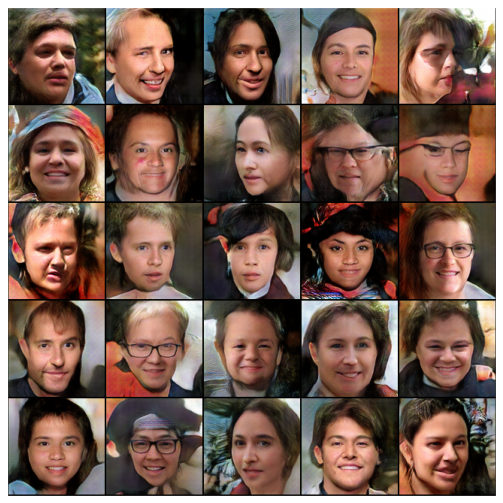

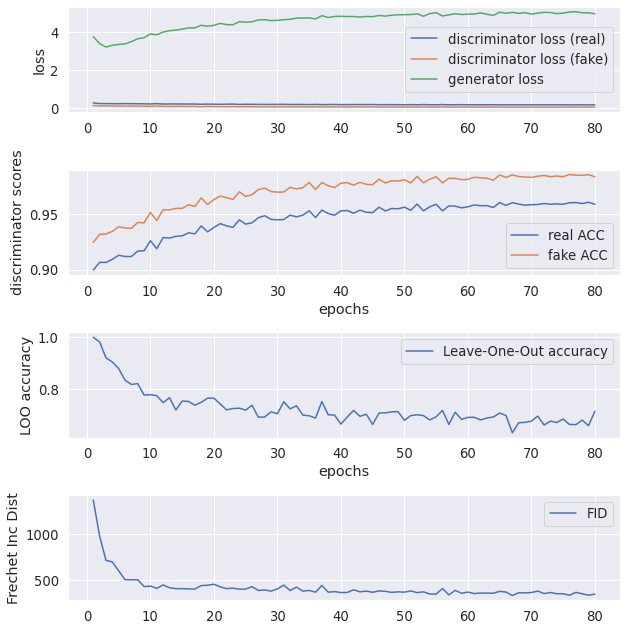

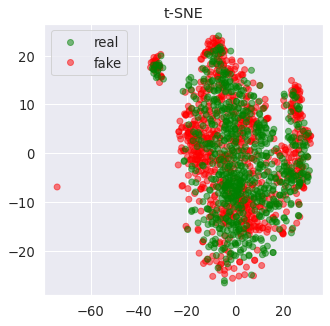

CPU times: user 19h 28min 47s, sys: 4min 47s, total: 19h 33min 35s
Wall time: 9h 45min 53s


In [47]:
%%time
h = run_train(epochs = 80, 
            discriminator_lr = 2e-4, 
            gen_lr_over_dis_lr = 1, 
            betas = (0.5, 0.999),
            loss_fn = nn.BCEWithLogitsLoss,
            batch_size = 32,
            dataset_divide = 1,
            half_life_of_lr = 1000,
            fit_kwargs=dict(
                noised_real_labels=0.05,
                noised_fake_labels=0.01, 
                soft_real_labels=0.0,
                soft_fake_labels=0.0, 
                buffer_batches=3, 
                extract_features_epoch=1, 
                flip_target=True, 
                flip_positive_part=0.005,
                flip_fake_part=0.,
                noise_real_images=0., 
                # noise_fake_images=0.0, 
                wgan=False,
                sigmoid_in_model=False,
                train_phases=False,
                loss_lim_dis=0.65,
                loss_lim_gen=1.,
                grad_penalty_k=10,
                samples_for_loo=750,
            )
        )

Сами картинки по большей части очень хороши. Кривые обучения вроде тоже хороши.

Кажется, модель недообучена (обучение длилось более 9 часов), так как и метрики продолжаются улучшаться, и лосс генератора медленно плавно растет. Возможно, мы столкнулись с convergence failure. А может, надо было пообучать еще часов 20.

Анимация обучения по эпохам.

![epochs_gif](outputs/_animated_.gif "epochs")

Сохраним удачные модели.

In [48]:
torch.save(generator, './generator_v05.pt')
torch.save(discriminator, './discriminator_v05.pt')

# Анализ результата

Вот так должно выглядеть стабильное обучение. Взято [отсюда](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/).

![sad](https://machinelearningmastery.com/wp-content/uploads/2019/07/Line-Plots-of-Loss-and-Accuracy-for-a-Stable-Generative-Adversarial-Network.png)

Ну в целом наши графики выглядят примерно так же. Но картинки говорят сами за себя - для таких простеньких моделей они вполне хороши. Лучше, чем у большинства классических хэндмейд ГАНов в интернете.

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений.

Для интереса сделаем сетку, где каждый ряд - это плавный переход от одного случайного латентного вектора к другому.

In [71]:
def show_generated_image_grid(n=9):
    l = latent_size
    xs = []

    for i in range(n):
        x1 = torch.randn(1, l)
        x2 = torch.randn(1, l)
        for j in np.linspace(0, 1, n):
            x = x1*j + x2*(1-j)
            xs.append(x)

    latent_grid = torch.vstack(xs)
    
    generator.eval()
    with torch.no_grad():
        image_grid = generator(latent_grid.to(device)).cpu()
        
    show_images(image_grid, nmax=n*n, figsize=(15, 15))

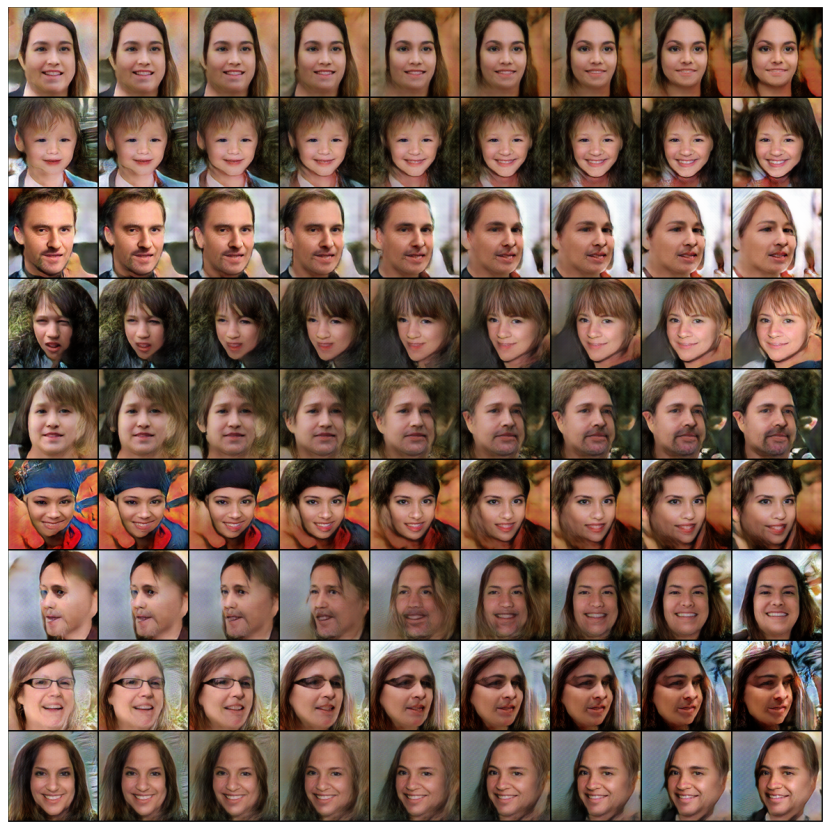

In [74]:
show_generated_image_grid()

Не фотореализм, конечно... Но многие лица прямо хороши.

# Выводы

- реализована классическая архитектура DCGAN для генерации разнообразных изображений лиц людей в разрешении 128х128

- реализованы дополнительные трюки для обучения:
    - переворот меток 0 и 1 при обучении для защиты от затухания градиентов
    - подмена меток на реальных фотографиях (выдача их за фейки) для защиты от коллапса мод
    - зашумление меток и soft labels
    - зашумление картинок
    - слои гауссовского шума в дискриминаторе и генераторе перед слоями свертки
    - буфер для сгенерированных изображений
    - добавлен Gradient Penalty, увеличивающий лосс при "длине" градиентов, отличающейся от единицы
    
- вручную экспериментально подобраны гиперпараметры обучения, в частности, количество фильтров в генераторе и дискриминаторе и размер батча. Все эти параметры критически важны для скорости обучения и качества работы сети

- реализованы расчет и отображение метрик:
    - получение эмбеддингов/латентных векторов изображений предобученной на imagenet сетью
    - Fréchet inception distance
    - Leave-one-out-1-NN классификация
    - t-SNE изображение признаков настоящих и сгенерированных изображений на двумерном графике

# Интересная литература:
- [оригинальная статья про WGAN](https://arxiv.org/pdf/1701.07875.pdf) - простая лосс функция, повышающая стабильность обучения
- [максимально дешевая и сердитая имплементация WGAN](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py). 
- более интересная и подробная [статья по WGAN со ссылкой на гитхаб](https://agustinus.kristia.de/techblog/2017/02/04/wasserstein-gan/)
- [гайд по проблемам обучения GAN](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/)
- [набор универсальных советов по обучению GAN](https://github.com/soumith/ganhacks)
- [имплементация спектральной нормализации](https://github.com/christiancosgrove/pytorch-spectral-normalization-gan)
- [10 советов про GANы](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [видео ProGAN implementation from scratch
](https://www.youtube.com/watch?v=nkQHASviYac) и его [гитхаб реализация](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/ProGAN)
- [генератор кошечек на гитхабе](https://github.com/simoninithomas/CatDCGAN/blob/master/Cat%20DCGAN.ipynb)
- примитивная и вполне рабочая [facegan_pytorch](https://github.com/ShivamShrirao/facegan_pytorch/blob/main/facegan_pytorch.ipynb) на гитхабе 
- код для лосса [Gradient Penalty](https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/tree/master/Computer_Vision/64-WGAN_with_Gradient_Penalty_from_Scratch_PyTorch) на гитхабе